Install iapws

In [0]:
!pip install iapws

Download data files

In [0]:
!wget https://raw.githubusercontent.com/msbonus/swhp/master/SWHP.csv
!wget https://raw.githubusercontent.com/msbonus/swhp/master/Water.csv

#Download and save the notebook as html
#!wget https://raw.githubusercontent.com/msbonus/swhp/master/main.ipynb
#!jupyter nbconvert --to html main.ipynb

all imports

In [0]:
import numpy as np
from iapws import iapws97
import csv
import matplotlib.pyplot as plt

Water properties

In [0]:
pa = 101325/10**6 #MPa
TK0 = 273.15

def WaterCp(Tw):
  return iapws97._Region1(Tw+TK0, pa)["cp"] #kJ/(kg*K)

def WaterDensity(Tw):
  return 1/iapws97._Region1(Tw+TK0, pa)["v"] #kg/m3

load inlet Water parameters

In [0]:
with open ('Water.csv', 'r') as csvFile:
  reader = csv.reader(csvFile, delimiter=';')
  InletWater = np.matrix(list(reader))
csvFile.close()


Definition of Class "Heat Pump"

In [0]:
def flt2str(float_num):
  return f"{float_num:.2f}".rstrip('0').rstrip('.')

class HeatPump:
  def __init__(self, Producer, Type, w_flow,
               Tw_in, Tw_out, h_flow, Th_out, Consumption):
    self.Producer = Producer
    self.Type = Type
    self.w_flow = float(w_flow)
    self.Tw_in = float(Tw_in)
    self.Tw_out = float(Tw_out)
    self.h_flow = float(h_flow)
    self.Th_out = float(Th_out)
    self.Consumption = float(Consumption)

  def __str__(self):
    return("Producer:\t" + self.Producer +
    "\nType:\t\t" + self.Type +
    "\nw_flow:\t\t" + flt2str(self.w_flow) +
    "\nTw_in:\t\t" + flt2str(self.Tw_in) +
    "\nTw_out:\t\t" + flt2str(self.Tw_out) +
    "\nh_flow:\t\t" + flt2str(self.h_flow) +
    "\nTh_out:\t\t" + flt2str(self.Th_out) +
    "\nConsumption:\t" + flt2str(self.Consumption))
    #       + self.Producer + "\t " + self.Type + "\t " + self.w_flow + "\t "
    #       + self.Tw_in + "\t " + self.Tw_out + "\t " + self.h_flow + "\t "
    #       + self.Th_out + "\t " + self.Consumption)
  
  def getW_flow(self):
    return self.w_flow
  
  def getTh_out(self):
    return self.Th_out
  
  def getQin(self, w_flow, Tw):
    return (w_flow * WaterDensity(Tw) * WaterCp(Tw) * 3 / 3600) #kW
  
  def getCOP(self, Tw):
    if ((Tw > self.Tw_in) and (Tw < self.Tw_out)):
      return (self.Th_out + TK0)/(self.Th_out - Tw)
    else:
      return 0    
  
  def getoutHeat(self, Qin, COP): 
  #if ((Tw > float(self.Tw_in)) and (Tw < float(self.Tw_out))):
    return ((Qin * COP)/(COP - 1)) #kW
  #else:
    #return 0 
  
  def getPel(self, COP, Qout):
     return (COP * Qout) #kW

Definiton of Class "Database"

In [0]:
class HeatPumpDB:
  DB = []
  def __init__(self):
    with open ('SWHP.csv', 'r') as csvFile:
      reader = csv.DictReader (csvFile, delimiter=';')
      self.DB = list(reader)
    csvFile.close()
  
  def getHeatPump_byID(self, ID):
    for entry in self.DB:
      if (int(entry["ID"]) == ID):
        return self.makeHeatPump(entry)
      
  def getHeatPump_byType(self, Type):
    for entry in self.DB:
      if (entry["Type"]) == Type:
        return self.makeHeatPump(entry)

  def makeHeatPump(self, entry):
    return HeatPump(entry["Producer"], entry["Type"], entry["w_flow"],
                    entry["Tw_in"], entry["Tw_out"], entry["h_flow"],
                    entry["Th_out"], entry["Consumption"])


COP

Producer:	Viessmann
Type:		WW302.B300
w_flow:		70
Tw_in:		8
Tw_out:		20
h_flow:		49.9
Th_out:		60
Consumption:	49.5


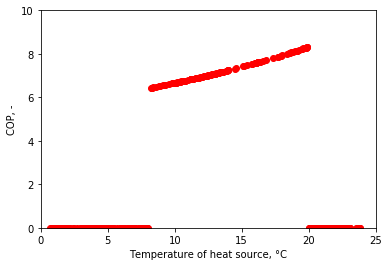

In [0]:
#create an instance of the database
HeatPumpDB1 = HeatPumpDB()

WP1 = HeatPumpDB1.getHeatPump_byID(0)
print(WP1)

Tw = InletWater[:,1] 

 #Tw = max(min(float(self.Tw_in), Tw), float(self.Tw_out))
#print (max(min(float(WP1.Tw_in), 11.1), float(WP1.Tw_out)))

COP = []
for i in range(len(Tw)):
  COP.append(WP1.getCOP(float(Tw[i])))
 
  
  
#plot (x = Temperature of Heat source, y = COP)
x = Tw
y = COP

plt.plot(x, y, "ro")
plt.xlabel('Temperature of heat source, °C')
plt.ylabel('COP, -')
plt.axis([0, 25, 0, 10])
plt.show()

main calculation

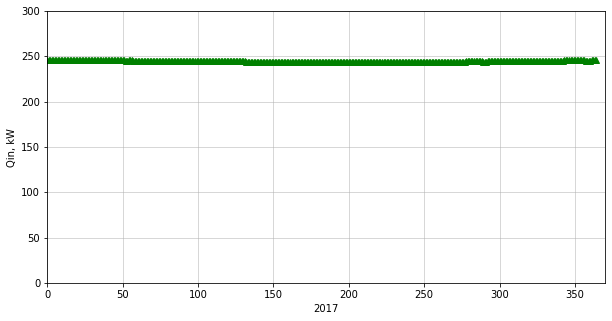

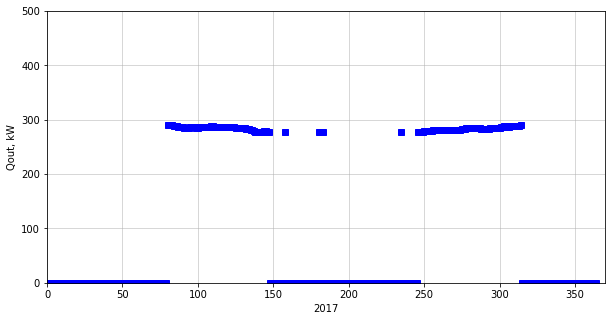

Qout_work =  141 days
Summary Heat capacity =  40024.30955829477 kW/a


In [0]:
Qin = []
for i in range(len(Tw)):
  Qin.append(WP1.getQin(WP1.getW_flow(), float(Tw[i])))

x = range(len(Qin))
y = Qin

plt.figure(figsize=(10,5))
plt.plot(x, y, "g^")
plt.xlabel('2017')
plt.ylabel('Qin, kW')
plt.axis([0, 370, 0, 300])
plt.grid(linestyle='-', linewidth=0.5)
plt.show()


Qout = []
Qout_work = 0
for i in range(len(Qin)):
  Qout.append(WP1.getoutHeat(Qin[i], COP[i]))
  if Qout[i]>0:
    Qout_work += 1

aQout = sum (Qout)  
  
x = range(len(Qout))
y = Qout

plt.figure(figsize=(10,5))
plt.plot(x, y, 'bs')
#plt.plot(x, y, marker='s', color='b')
plt.xlabel('2017')
plt.ylabel('Qout, kW')
plt.axis([0, 370, 0, 500])
plt.grid(linestyle='-', linewidth=0.5)
plt.show()
  

print ("Qout_work = ", Qout_work, "days")
print ("Summary Heat capacity = ", aQout, "kW/a")



Seasonal Performance Factor

In [0]:

print("Work Factor = ", (Qout_work/365)*100, "%/a")

SPF = aQout/(Qout_work*WP1.Consumption)
print ("Seasonal Performance Factor = ", SPF, "kW/a")



Work Factor =  38.63013698630137 %/a
Seasonal Performance Factor =  5.734552555096321 kW/a


el.consumption

In [0]:
def getPel(self, COP, Qout):
     return (COP * Qout) #kW


Pel = []
for i in range(len(Qout)):
  Pel.append(getPel(WP1.getCOP(float(Tw[i])), Qout[i]))
print (Pel(60))

x = range(len(Qout))
y = Pel

plt.figure(figsize=(10,5))
plt.plot(x, y, "g^")
plt.xlabel('2017')
plt.ylabel('Qin, kW')
plt.axis([0, 370, 0, 300])
plt.grid(linestyle='-', linewidth=0.5)
plt.show()

TypeError: ignored

draft

Self-function

In [0]:
class Rechteck():
  def __init__(self,breite,laenge):
    self.myLaenge =laenge
    self.myBreite =breite
    
  def printRechteck(self):
    print('Das Rechteck hat die Laenge '+str(self.myLaenge)+' und die Breite'+str(self.myBreite))
  
  def calcUmfang(self):
    return 2*self.myBreite + 2*self.myLaenge
  
  def calcFI(self):
    return self.myBreite * self.myLaenge
 
  def hasBiggerFlaecheninhalt(self, other):
    selfFI = self.calcFI()
    otherFI = other.calcFI()
    return selfFI > otherFI
    
rechteck1 = Rechteck(10,5)
rechteck2 = Rechteck(20,2)

rechteck1.printRechteck()
print(rechteck1.calcFI())
print(rechteck2.calcFI())
print(rechteck1.hasBiggerFlaecheninhalt(rechteck2))
         
      

graph

In [0]:

def Qout(self, Qin, COP):
  return (Qin*COP)/(COP - 1)

def h_flow(self, Qout, COP):
  return Qout/(rho*Cp*(Th-Tw)) # Sebastian fragen

def achieved

print ("COP = ", COP, "-")
print ("Qout = ", Qout, "kW")
print ("Heat flow = ", h_flow, "m^3/h")